## Physical Geography

In [12]:
%load_ext autoreload
%autoreload 2

from world_simulator import run_river_skeleton_pipeline, test_noise, generate_fractal_noise
from world_simulator import GPUThermalEroder, CoastalTaper

from world_simulator import HydrologyAnalyzer, validate_arrow_directions, plot_flow, CalculateFlowMagnitude, plot_river_hierarchy, assign_river_widths, plot_river_physics, save_hydro_network, validate_topology_continuity




import os
import geopandas as gpd
import numpy as np
import rasterio
from gdgtm import change_raster_res


vector_src_dir = "/home/pete/Documents/wfrp/source_vectors/"
raster_src_dir = "/home/pete/Documents/wfrp/source_rasters/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Base DEM setup

Here we take a georeferenced, trimmed corase altitude map, we load it, increase resolution, and then we smooth it.

We use an erosion approach to overal smoothing and aim for Int16 data type - which gives us some serious mileage in the "disk saving department" - 100s of MBs.

The exact maths are indicated in the class docstring for the GPUThermalEroder. For now it is relevant to note that we went for a short erosion (100 steps), slow erosion rate (0.05), and a high threshold of 2. What this means is that we preserve most of the high ground on the map, while introducing just a little smoothing around the slopes to remove the blockiness. Not perfect, but the step below will take care of doing perfect :)

What this will not do is getting a good coastal taper. For this we use the CoastalTaper class.
For this we set ourselves at 250 pixels from the shore (which means base DEM elevation is reached some 27.25km from the Sea of Claws). The power is the default of 2 - this means a wide coastal plain and a steep rise that still preserves the hills in the north of Nordland.

In [7]:
### Change resolution to 125m

src_raster = os.path.join(raster_src_dir, "wfrp_empire_topo_base_dem.tif")
dst_raster = os.path.join(raster_src_dir, "wfrp_empire_topo_base_dem_high_res.tif") 

change_raster_res(125, src_raster, dst_raster)

'Resolution meets target, file exists: /home/pete/Documents/wfrp/source_rasters/wfrp_empire_topo_base_dem_high_res.tif'

In [10]:
src_raster = os.path.join(raster_src_dir, "wfrp_empire_topo_base_dem_high_res.tif") 
dst_raster = os.path.join(raster_src_dir, "wfrp_empire_smoothed_topo.tif")

if __name__ == "__main__":
    eroder = GPUThermalEroder(talus_threshold=2, erosion_rate=0.05)
    
    # 1. Load
    raw_dem = eroder.load_dem(src_raster)
    
    # 2. Process
    smoothed_dem = eroder.process(raw_dem, iterations=100)
    
    # 3. Save
    eroder.save_dem(smoothed_dem, dst_raster)  ### Note: output is hard-coded to be Int16!
    print("Done.")


Done.


In [19]:
## Apply Coastal Taper

src_dir = "/home/pete/Documents/wfrp"
sea_vector = os.path.join(src_dir, "source_vectors/wfrp_empire_sea_poly.gpkg")
dem_raster = os.path.join(src_dir, "source_rasters/wfrp_empire_smoothed_topo.tif")
dst_raster = os.path.join(src_dir, "source_rasters/wfrp_empire_tapered_topo.tif")

# 1. Setup
# We want the land to taper off over 500 pixels from the coastline
taper_tool = CoastalTaper(taper_distance_px=250.0)

# 2. Load Inputs
# This reads the raster AND converts the vector file to a boolean mask internally
raw_dem = taper_tool.load_inputs(
    dem_path=dem_raster, 
    sea_vector=sea_vector # Can be path or GDF
)

# 3. Generate the Gradient Field
# Power 2.0 gives a parabolic curve (smooth start), 0.1 downsample makes it fast
taper_tool.generate_taper_map(power=2, downsample_factor=0.1)

# 4. Apply
# Returns float32 version with taper applied
processed_dem = taper_tool.apply(raw_dem)

# 5. Save
# Automatically converts to Int16, sets NoData = -32768, and compresses
taper_tool.save_result(processed_dem, dst_raster)

INFO: Loading inputs from /home/pete/Documents/wfrp/source_rasters/wfrp_empire_smoothed_topo.tif...
INFO: Loading Sea Vector from disk...
INFO: Rasterizing Sea Vector to match DEM profile...
INFO: Generating Coastal Taper (Dist=250.0px, Power=2)...
INFO: Applying Coastal Taper (returning float32)...
INFO: Saving result to /home/pete/Documents/wfrp/source_rasters/wfrp_empire_tapered_topo.tif as Int16...


### Vectorizing the river net from QGIS polys

The goal here is to take a bunch of QGIS polygons and change them into an actual net of lines for downstream processing.

In [ ]:
# if __name__ == "__main__":
#     # Example configuration
#     IN_FILE = os.path.join(vector_src_dir, "wfrp_empire_rivers_poly.gpkg")
#     OUT_FILE = os.path.join(vector_src_dir, "wfrp_empire_rivers_line.gpkg")
    
#     # Config
#     GAP_TOLERANCE = 3500     # 20km gap filling
#     INTERP_DISTANCE = 250     # 500m vertex resolution
#     PRUNE = 3500
    
#     if os.path.exists(IN_FILE):
#         run_river_skeleton_pipeline(IN_FILE, OUT_FILE, GAP_TOLERANCE, INTERP_DISTANCE, PRUNE)
#     else:
#         print(f"File not found: {IN_FILE}")

### Build the topography and the flow maps

In [ ]:
# ### Phase 1: Make the rivers flow and make them have the right size.

# if __name__ == "__main__":

#     # rivers_path = os.path.join(vector_src_dir, "wfrp_empire_rivers_line.gpkg")
#     sea_path = os.path.join(vector_src_dir, "wfrp_empire_sea_poly.gpkg")
#     lakes_path = os.path.join(vector_src_dir, "wfrp_empire_lakes_poly.gpkg")
#     rivers_path = os.path.join(vector_src_dir, "wfrp_empire_rivers_line.gpkg")
    
#     rivers = gpd.read_file(rivers_path) # The output from skeletonization
#     sea = gpd.read_file(sea_path)       # You need this
#     lakes = gpd.read_file(lakes_path)   # You need this (Canonical lakes)

#     ### Step 1: Orient the rivers in the correct direction.
#     analyzer = HydrologyAnalyzer(rivers, sea, lakes)
#     oriented_rivers = analyzer.run()
#     validate_arrow_directions(oriented_rivers, analyzer.G)
#     # plot_flow(oriented_rivers, sea, lakes)

#     ### Step 2: Establish river hierarchy
#     # 1. Get the Directed Graph from the Phase 1 Analyzer
#     flow_calculator = CalculateFlowMagnitude(analyzer.DiG)
#     # 2. Calculate Magnitude
#     dag_with_flow = flow_calculator.run()
#     # 3. Visualize
#     # plot_river_hierarchy(dag_with_flow, sea, lakes)

In [ ]:
# if __name__ == "__main__":
#     OUT_FILE = os.path.join(vector_src_dir, "wfrp_empire_major_rivers_net.gpkg")
#     ### Step 3: Work out river widths:
#     rivers_with_width = assign_river_widths(
#         dag_with_flow, 
#         min_width=20.0,    # Source streams are 20m wide
#         max_width=1000.0,   # The Reik is 800m wide at Altdorf - we make it 1000 for our 250m grid.
#         scale_factor=100.0  # Multiplier for the log growth
#     )
    
#     # 2. Restore CRS (Important for buffering!)
#     rivers_with_width.set_crs(rivers.crs, inplace=True)
    
#     # 3. Visualize
#     # plot_river_physics(rivers_with_width, sea, lakes)
#     save_hydro_network(rivers_with_width, OUT_FILE)

In [4]:
# validate_topology_continuity(rivers_with_width)

--- TOPOLOGY CONTINUITY CHECK ---
Checked 100 junctions.
SUCCESS: Water flows continuously from line to line.


### Testing pit

The cells below are for testing custom functions

In [34]:
%load_ext autoreload
%autoreload 2

INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_124556.log
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from world_simulator import FractalLayer, FractalBlender

# --- 1. SETUP CONTEXT ---
# Load the raw assets that the blender will need to reference
print("Loading Context Assets...")

src_dir = "/home/pete/Documents/wfrp"
SEA_VECTOR = os.path.join(src_dir, "source_vectors/wfrp_empire_sea_high_res_poly.gpkg")
NORTH_BLOB_VECTOR = os.path.join(src_dir, "source_vectors/wfrp_empire_north_blob.gpkg")
DEM_RASTER = os.path.join(src_dir, "source_rasters/wfrp_empire_topo_tapered.tif")

# Base Elevation (The Canvas)
# Pre-tapered in previous steps? Or raw? Let's assume raw or pre-tapered.
with rasterio.open(DEM_RASTER) as src:
    base_dem = src.read(1)
    profile = src.profile.copy()
    pixel_size = src.res[0] # e.g. 125m

# Vectors (The Shapes)
# We load these once so we don't re-read disk for every layer
vectors = {
    "north_blob": gpd.read_file(NORTH_BLOB_VECTOR).to_crs(src.crs),
    "sea": gpd.read_file(SEA_VECTOR).to_crs(src.crs)
    }

Loading Context Assets...


In [97]:
# --- 2. THE RECIPE (Declarative Configuration) ---
# This list is your "Source of Truth" for the geology.
# Tweak these numbers to change the world.

terrain_recipe = [
    # Layer 1: Global Rolling Hills
    # Low frequency, gentle amplitude. Applies everywhere (mask=None).
    FractalLayer(
        name="Global Base",
        seed=10,
        frequency_scale=400.0,  # Broad features
        vertical_scale=150.0,   # +/- 150m height variation
        fractal_type="FBM",     # Smooth hills
        mask_config=None
    ),

    # Layer 2: The Northern Roughness (Spatial Creep)
    # Uses 'vector_fade' to creep noise in over 200km from the North border.
    FractalLayer(
        name="Northern Badlands",
        seed=20,
        frequency_scale=120.0,   # Medium-High frequency (Jagged)
        vertical_scale=150.0,   # Significant height addition
        fractal_type="RigidMulti", # Sharp ridges/canyons
        mask_config={
            "type": "vector_fade",
            "vector_key": "north_blob", # References the 'vectors' dict above
            "fade_km": 300.0,           # The gradient length
            "invert": False
        }
    ),

    # Layer 3: Alpine Spikes (Altitude Dependent)
    # Uses 'altitude' to add noise only to existing mountains.
    FractalLayer(
        name="High Peak Detail",
        seed=30,
        frequency_scale=40.0,   # Very high frequency (Rock texture)
        vertical_scale=450.0,  # Massive spikes
        fractal_type="RigidMulti",
        mask_config={
            "type": "altitude",
            "min_height": 400.0,   # Starts appearing at 1000m
            "fade_height": 1000.0    # Fully active by 1500m
        }
    ),
    
    # Layer 4: Coastal Micro-Noise (Optional)
    # Adds subtle grit near the sea to break up flat beaches
    FractalLayer(
        name="Coastal Grit",
        seed=40,
        frequency_scale=10.0,
        vertical_scale=20.0,
        fractal_type="FBM",
        mask_config={
            "type": "vector_fade",
            "vector_key": "sea",
            "fade_km": 15.0,
            "invert": False # Fade OUT as we go inland
        }
    )
]

In [98]:
# --- 3. EXECUTION (The Engine) ---
print("Running Fractal Blender...")

# Initialize the Processor
blender = FractalBlender(
    base_dem=base_dem,
    vector_context=vectors,
    profile=profile
)

# Run the Recipe
final_terrain = blender.process(terrain_recipe)

Running Fractal Blender...
INFO: Starting Fractal Blender (4 layers)...
INFO:   [1/4] Processing Layer: Global Base
INFO:   [2/4] Processing Layer: Northern Badlands
INFO: Rasterizing 1 vector features into mask...
INFO:   [3/4] Processing Layer: High Peak Detail
INFO:   [4/4] Processing Layer: Coastal Grit
INFO: Rasterizing 493 vector features into mask...


In [99]:
import gc

# --- CONFIGURATION ---

src_dir = "/home/pete/Documents/wfrp"

OUTPUT_FRACTAL_PATH = os.path.join(src_dir, "source_rasters/wfrp_empire_topo_complete.tif")
INT16_NODATA = -32768  # Standard Int16 sentinel
SAFE_MIN = -32000      # Buffer to prevent valid data hitting nodata
SAFE_MAX = 32000

print(f"Saving final output to: {OUTPUT_FRACTAL_PATH}")

# 1. Recover the Void Mask (Original NoData)
# We assume 'base_dem' or 'src_nodata' is still available from the loading step.
# If not, we infer it from extreme negative values in the base.
if 'src_nodata' in locals() and src_nodata is not None:
    # If the original DEM had a defined NoData value (e.g. -3.4e38)
    void_mask = (base_dem == src_nodata)
else:
    # Fallback: Treat deep negative outliers as void
    void_mask = (base_dem < -10000)

# 2. Round and Clip (Float32 -> Int16)
print("  Converting to Int16...")
# Round to nearest meter
# Use a temporary variable for the rounded data
# We clip to [-32000, 32000] to ensure we never accidentally use the sentinel value -32768 for real data
final_int_data = np.clip(np.round(final_terrain), SAFE_MIN, SAFE_MAX).astype(np.int16)

# 3. Apply NoData Sentinel
# Force the void areas to the specific Int16 NoData value
final_int_data[void_mask] = INT16_NODATA

# 4. Update Profile
# We must tell GeoTIFF that this is now Int16 and what the NoData value is
profile.update(
    dtype=rasterio.int16,
    count=1,
    compress='lzw',
    nodata=INT16_NODATA
)

# 5. Write to Disk
print("  Writing to disk...")
with rasterio.open(OUTPUT_FRACTAL_PATH, 'w', **profile) as dst:
    dst.write(final_int_data, 1)

print(f"  Successfully saved to {OUTPUT_FRACTAL_PATH}")

# 6. Memory Cleanup
print("  Dumping memory...")
del final_terrain
del final_int_data
# Force Python garbage collector to reclaim the ~1GB+ RAM immediately
gc.collect()

print("Done.")

Saving final output to: /home/pete/Documents/wfrp/source_rasters/wfrp_empire_topo_complete.tif
  Converting to Int16...
  Writing to disk...
  Successfully saved to /home/pete/Documents/wfrp/source_rasters/wfrp_empire_topo_complete.tif
  Dumping memory...
Done.


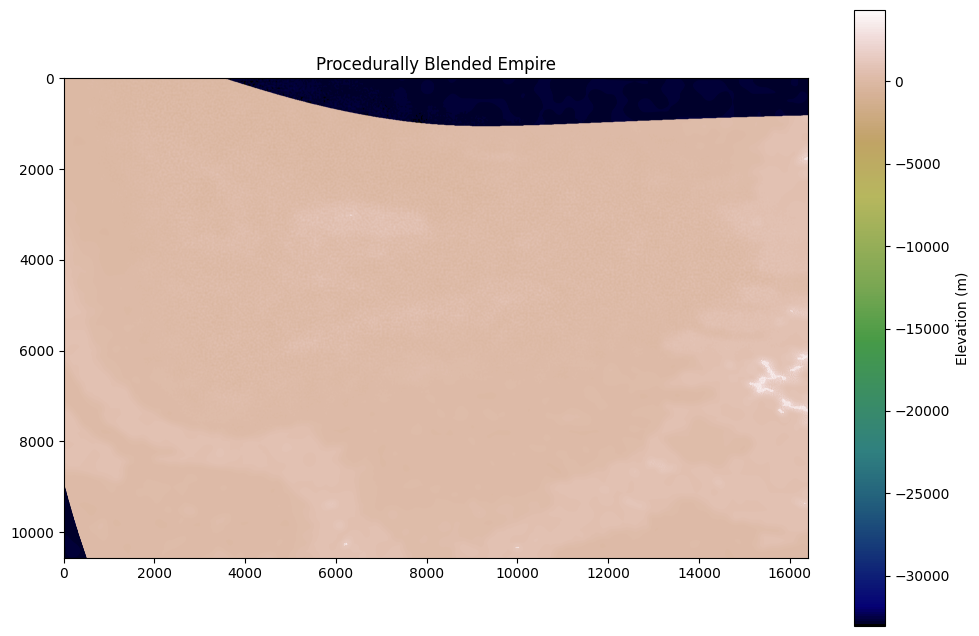

In [82]:
# --- 4. VISUALIZATION ---
plt.figure(figsize=(12, 8))
plt.imshow(final_terrain, cmap='gist_earth')
plt.colorbar(label="Elevation (m)")
plt.title("Procedurally Blended Empire")
plt.show()

In [57]:
import os
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from world_simulator import vector_to_mask, CoastalTaper

src_dir = "/home/pete/Documents/wfrp"
SEA_VECTOR = os.path.join(src_dir, "source_vectors/wfrp_empire_sea_poly.gpkg")
DEM_RASTER = os.path.join(src_dir, "source_rasters/wfrp_empire_topo_high_high_res.tif")

# Taper Settings
TARGET_TAPER_KM = 100.0  # 100km fade-in
CURVE_POWER = 2       # 2.0 = Quadratic (Slow start, steeper finish)

# --- 2. LOAD DATA ---
print("Loading data...")
with rasterio.open(DEM_RASTER) as src:
    base_dem = src.read(1)
    profile = src.profile.copy()
    dem_crs = src.crs
    pixel_size_x = src.res[0] # Assuming square pixels (approx 125m)

print(f"  DEM Resolution: {pixel_size_x:.2f}m per pixel")

sea_gdf = gpd.read_file(SEA_VECTOR)
if sea_gdf.crs != dem_crs:
    print("  Aligning Sea Vector CRS...")
    sea_gdf = sea_gdf.to_crs(dem_crs)

# --- 3. PREPARE MASK ---
print("Creating Sea Mask...")
sea_mask = vector_to_mask(sea_gdf, profile)

# --- 4. RUN COASTAL TAPER ---
# Calculate pixels needed for 200km
taper_px = (TARGET_TAPER_KM * 1000) / pixel_size_x
print(f"Configuring Taper: {TARGET_TAPER_KM}km requires ~{int(taper_px)} pixels.")

taper_engine = CoastalTaper(sea_mask, taper_distance_px=taper_px)

# Generate the gradient map
# Using downsample_factor=0.1 for speed (calculate on 1.6k raster instead of 16k)
taper_map = taper_engine.generate_taper_map(
    power=CURVE_POWER, 
    downsample_factor=0.1
)

# Apply to DEM
tapered_dem = taper_engine.apply(base_dem)

Loading data...
  DEM Resolution: 125.00m per pixel
Creating Sea Mask...
INFO: Rasterizing 11 vector features into mask...
Configuring Taper: 100.0km requires ~800 pixels.
INFO: Generating Coastal Taper (Dist=800.0px, Power=2)...
INFO: Applying Coastal Taper (returning int16)...


In [58]:
print(f"Saving Int16 output to: {OUTPUT_PATH}")
OUTPUT_PATH = os.path.join(src_dir, "source_rasters/test_dem_taper.tif") 
# Define a safe NoData value for Int16
INT16_NODATA = -32768

# 1. Identify original NoData areas
# (Using the base_dem from the loading step to ensure we don't turn void into land)
if 'src_nodata' in locals() and src_nodata is not None:
    nodata_mask = (base_dem == src_nodata)
else:
    # Fallback: assume anything super negative is void
    nodata_mask = (base_dem < -10000)

# 2. Round and Clip
# Round floats to nearest meter
rounded_dem = np.round(tapered_dem)

# Clip to safe valid range (-32000 to 32000)
# We avoid -32768 so it stays reserved for NoData
clipped_dem = np.clip(rounded_dem, -32000, 32000)

# 3. Apply NoData and Cast
clipped_dem[nodata_mask] = INT16_NODATA
final_int_dem = clipped_dem.astype(np.int16)

# 4. Update Profile
profile.update(
    dtype=rasterio.int16,
    count=1,
    compress='lzw',
    nodata=INT16_NODATA
)

# 5. Write
with rasterio.open(OUTPUT_PATH, 'w', **profile) as dst:
    dst.write(final_int_dem, 1)

print("Done.")

Saving Int16 output to: /home/pete/Documents/wfrp/source_rasters/test_dem_taper.tif
Done.


Visualizing results...


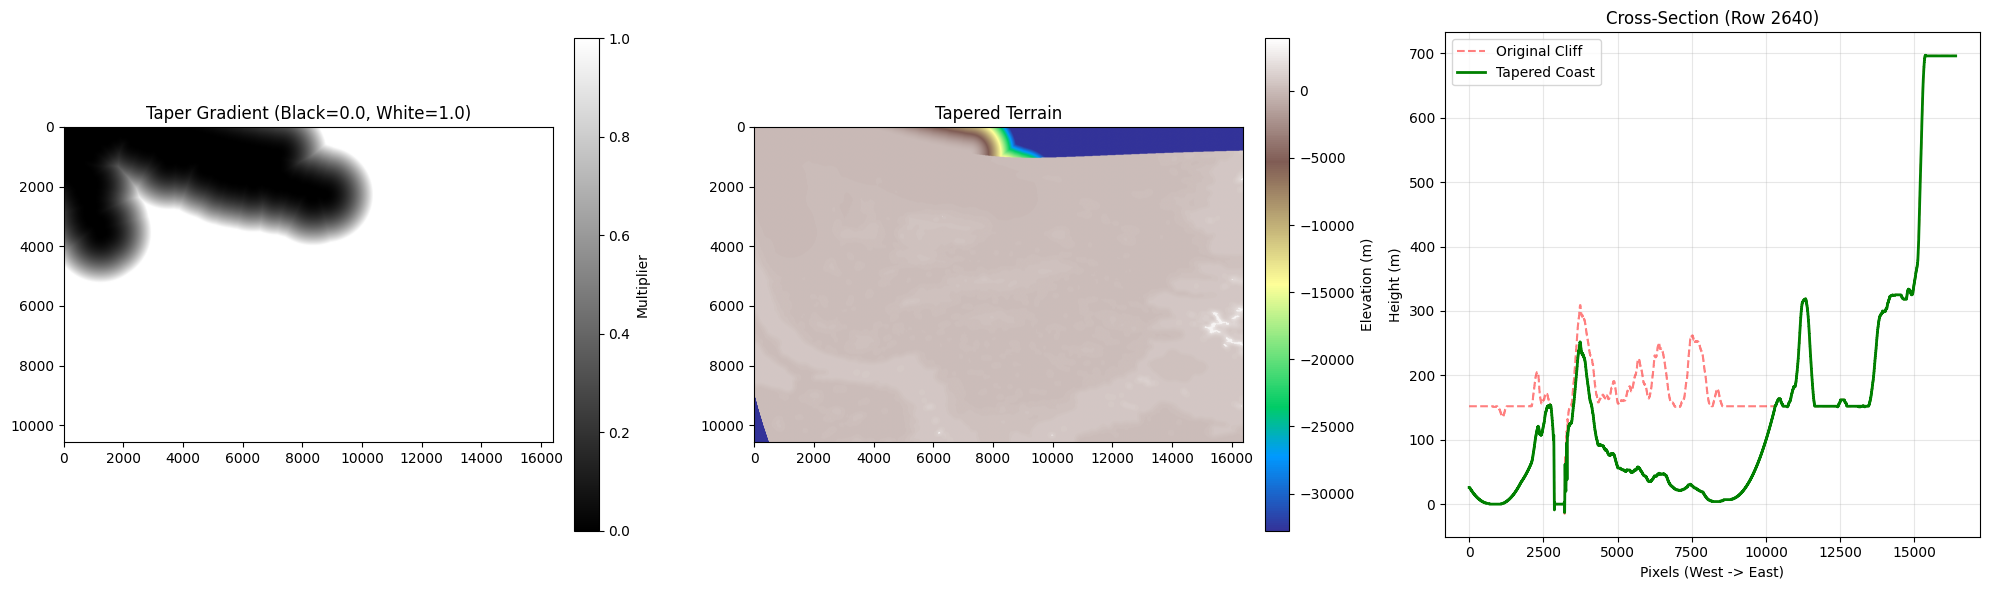

In [52]:
# Apply to DEM
final_dem = tapered_dem

# --- 5. VISUALIZATION ---
print("Visualizing results...")
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# A. The Taper Map (The Multiplier)
im1 = ax[0].imshow(taper_map, cmap='gray', vmin=0, vmax=1)
ax[0].set_title("Taper Gradient (Black=0.0, White=1.0)")
plt.colorbar(im1, ax=ax[0], label="Multiplier", fraction=0.046, pad=0.04)

# B. The Resulting DEM
im2 = ax[1].imshow(final_dem, cmap='terrain')
ax[1].set_title("Tapered Terrain")
plt.colorbar(im2, ax=ax[1], label="Elevation (m)", fraction=0.046, pad=0.04)

# C. Cross-Section Analysis (The Truth Test)
# We take a slice through the middle of the map to see the curve profile
mid_y = final_dem.shape[0] // 4
ax[2].plot(base_dem[mid_y, :], label="Original Cliff", color='red', alpha=0.5, linestyle='--')
ax[2].plot(final_dem[mid_y, :], label="Tapered Coast", color='green', linewidth=2)
ax[2].set_title(f"Cross-Section (Row {mid_y})")
ax[2].set_ylabel("Height (m)")
ax[2].set_xlabel("Pixels (West -> East)")
ax[2].legend()
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Rasterizing base vector...
INFO: Rasterizing 1 vector features into mask...
INFO: Fractalizing edges (Scale=60.0, Mag=20.0, Pers=0.45)...
INFO:   Starting parallel SDF calculation...


INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_111350.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_111351.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_111351.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_111351.log
INFO:   Parallel SDF reconstruction complete.
INFO: Fractalizing edges (Scale=10.0, Mag=150.0, Pers=0.65)...
INFO:   Starting parallel SDF calculation...


INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_111352.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_111352.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_111352.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_111352.log
INFO:   Parallel SDF reconstruction complete.


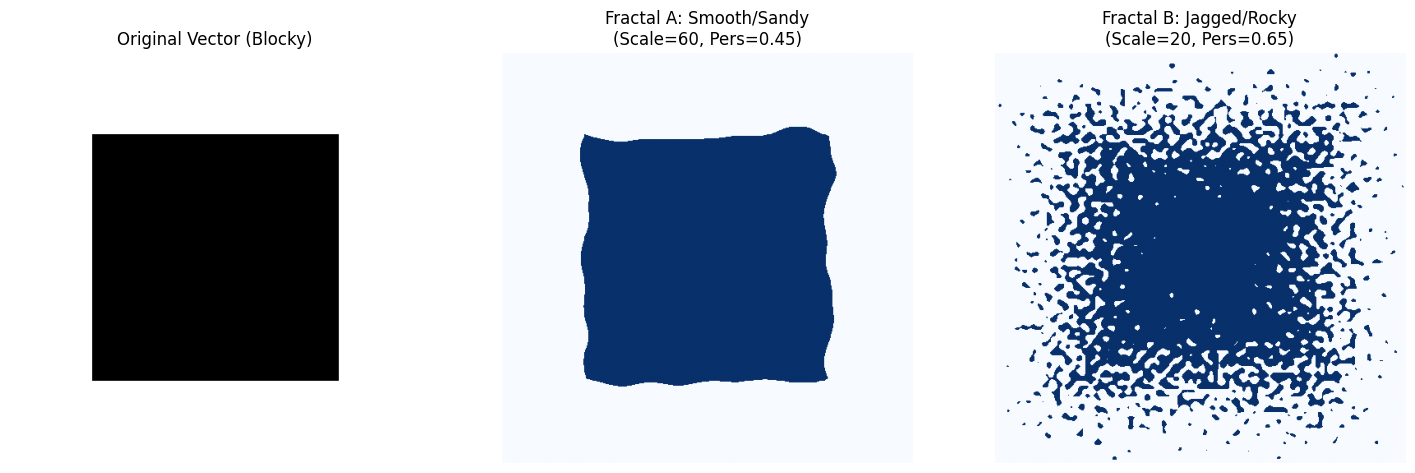

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
# Adjust import based on your actual package structure
from world_simulator import vector_to_mask, roughen_mask_edges

# 1. Setup Synthetic Data
# Create a blank canvas (representing your target raster resolution)
width, height = 500, 500
transform = rasterio.transform.from_origin(0, 500, 1, 1) # 1m resolution for simplicity
dummy_profile = {
    'height': height,
    'width': width,
    'transform': transform
}

# Create a "Blocky" Polygon (e.g., a simple square)
# This simulates your low-res vector data
poly = Polygon([(100, 100), (100, 400), (400, 400), (400, 100)])
gdf = gpd.GeoDataFrame({'geometry': [poly]})

# 2. Convert to Base Mask
print("Rasterizing base vector...")
base_mask = vector_to_mask(gdf, dummy_profile)

# 3. Run Fractalization (The Test)
# Test A: Smooth Coast (Sandy bays)
# High Scale (Broad shapes), Low Persistence (Smooth)
mask_smooth = roughen_mask_edges(
    base_mask, 
    seed=101, 
    scale=60.0, 
    magnitude=20.0, 
    persistence=0.45
)

# Test B: Jagged Coast (Fjords/Rocky)
# Low Scale (High freq), High Persistence (Rough)
mask_jagged = roughen_mask_edges(
    base_mask, 
    seed=102, 
    scale=10.0, 
    magnitude=150.0, 
    persistence=0.65
)

# 4. Visualization
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(base_mask, cmap='Greys')
ax[0].set_title("Original Vector (Blocky)")

ax[1].imshow(mask_smooth, cmap='Blues')
ax[1].set_title("Fractal A: Smooth/Sandy\n(Scale=60, Pers=0.45)")

ax[2].imshow(mask_jagged, cmap='Blues')
ax[2].set_title("Fractal B: Jagged/Rocky\n(Scale=20, Pers=0.65)")

for a in ax: a.axis('off')
plt.show()

In [66]:
import os
import numpy as np
import rasterio
import geopandas as gpd
from world_simulator import vector_to_mask, roughen_mask_edges

src_dir = "/home/pete/Documents/wfrp"

# --- 1. CONFIGURATION ---
# Replace with your actual paths
# We use the 'Sea' poly for this test, but you can swap for 'Lakes'
VECTOR_PATH = os.path.join(src_dir, "source_vectors/wfrp_empire_lakes_poly.gpkg")
# VECTOR_PATH = os.path.join(src_dir, "source_vectors/wfrp_empire_sea_poly.gpkg")
REFERENCE_RASTER_PATH = os.path.join(src_dir, "source_rasters/wfrp_empire_topo_high_high_res.tif")
OUTPUT_PATH = os.path.join(src_dir, "source_rasters/test_fractal_lakes.tif")

# --- 2. LOAD REFERENCE DATA ---
print(f"Loading reference: {REFERENCE_RASTER_PATH}")
with rasterio.open(REFERENCE_RASTER_PATH) as src:
    profile = src.profile.copy()
    ref_crs = src.crs
    ref_shape = (src.height, src.width)
    
print(f"Target Resolution: {src.width}x{src.height}")

# --- 3. LOAD & ALIGN VECTOR ---
print(f"Loading vector: {VECTOR_PATH}")
gdf = gpd.read_file(VECTOR_PATH, layer = "wfrp_empire_lakes")
# gdf = gpd.read_file(VECTOR_PATH)

if gdf.crs != ref_crs:
    print(f"  Reprojecting vector from {gdf.crs} to {ref_crs}...")
    gdf = gdf.to_crs(ref_crs)

# --- 4. GENERATE BASE MASK ---
print("Rasterizing base blocky mask...")
base_mask = vector_to_mask(gdf, profile)

# --- 5. GENERATE FRACTAL VARIANTS ---

# Fractal Control: You control D directly via the Persistence of the noise summation.

#     High Persistence (0.65) = High Dimension (1.35) = Fjords and splintered islands.

#     Low Persistence (0.45) = Low Dimension (1.1) = Sweeping sandy bays.


mask = roughen_mask_edges(
    base_mask,
    seed=101,
    scale=30.0,
    magnitude=5.0,
    persistence=0.3,
    fractal_type='RigidMulti',
    pre_smooth = 10
)

Loading reference: /home/pete/Documents/wfrp/source_rasters/wfrp_empire_topo_high_high_res.tif
Target Resolution: 16395x10562
Loading vector: /home/pete/Documents/wfrp/source_vectors/wfrp_empire_lakes_poly.gpkg
Rasterizing base blocky mask...
INFO: Rasterizing 86 vector features into mask...
INFO: Fractalizing edges (Scale=30.0, Mag=5.0, Pers=0.3)...
INFO:   Pre-smoothing mask (Sigma=10)...


Smoothing:   0%|                                                                                                                                                                            | 0/54 [00:00<?, ?it/s]

INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251205_185253.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_202512

INFO:   Starting parallel SDF calculation...


INFO:   Parallel SDF reconstruction complete.


In [68]:
# --- 6. SAVE TO DISK (Optimized) ---
print(f"Saving 3-Band comparison to {OUTPUT_PATH}...")

# Prepare Profile for Byte output (0-255)
# We use 3 bands so you can toggle them in QGIS to compare
profile.update(
    dtype=rasterio.uint8,
    compress='lzw',
    nodata=0
)

# Convert boolean (True/False) to Uint8 (255/0) for visibility
def to_byte(arr):
    return (arr * 255).astype(np.uint8)

with rasterio.open(OUTPUT_PATH, 'w', **profile) as dst:
    dst.write(to_byte(mask), 1)


print("Done! Open in QGIS and check the bands.")

Saving 3-Band comparison to /home/pete/Documents/wfrp/source_rasters/test_fractal_lakes.tif...
Done! Open in QGIS and check the bands.


Exception ignored in: <function ResourceTracker.__del__ at 0x74262b57dbc0>
Traceback (most recent call last):
  File "/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x743cb0989bc0>
Traceback (most recent call last):
  File "/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [E

/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251203_205609.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251203_205609.log
INFO: Applying 3 noise rules to base terrain...
INFO:   Rule 1: Scale=40.0, Mult=400.0, Seed=0


INFO:   Rule 2: Scale=20.0, Mult=800.0, Seed=1


INFO:     Filtered by Elevation > 500
INFO:     Filtered by Mask 'north'
INFO:   Rule 3: Scale=5.0, Mult=3200.0, Seed=3


INFO:     Filtered by Elevation > 2000
INFO: Terrain composition complete.


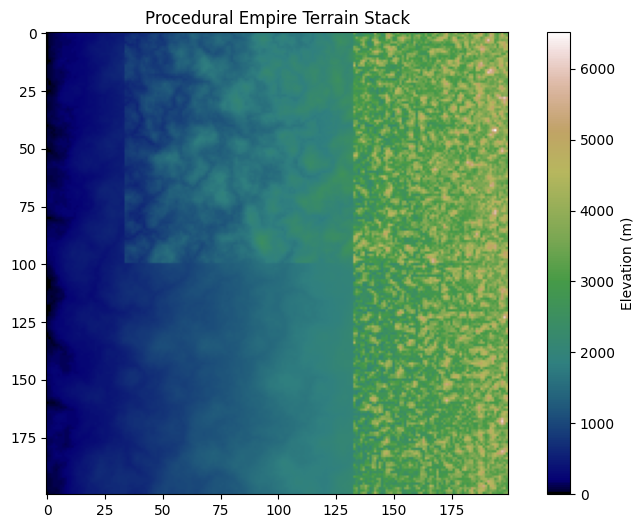

In [1]:
# --- IMPORTS ---
import numpy as np
import matplotlib.pyplot as plt
from world_simulator import apply_noise_rules, NoiseRule

# 1. Create Dummy Data
# Base DEM: A ramp from 0 to 3000m
height, width = 200, 200
base_dem = np.linspace(0, 3000, width).reshape(1, width).repeat(height, axis=0)

# Mask: "North" is the top half of the map
north_mask = np.zeros((height, width), dtype=bool)
north_mask[0:100, :] = True 

mask_lib = {'north': north_mask}

# 2. Define Your Rules
empire_rules = [
    # General Noise (Frequency 400, Multiplier 400) - Everywhere
    NoiseRule(seed=0, scale=40.0, multiplier=400.0), 
    
    # High Hills (Frequency 200, Mult 800) - Above 500m AND North
    NoiseRule(seed=1, scale=20.0, multiplier=800.0, min_elevation=500, mask_layer='north'),
    
    # Mountains (Frequency 50, Mult 3200) - Above 2000m (Anywhere)
    NoiseRule(seed=3, scale=5.0, multiplier=3200.0, min_elevation=2000)
]

# 3. Apply
final_terrain = apply_noise_rules(base_dem, empire_rules, mask_lib)

# 4. Visualize
plt.figure(figsize=(10, 6))
plt.imshow(final_terrain, cmap='gist_earth')
plt.colorbar(label="Elevation (m)")
plt.title("Procedural Empire Terrain Stack")
plt.show()

INFO: Smart-flattening lakes to local shoreline elevation...
INFO:   Found 2 distinct lakes.


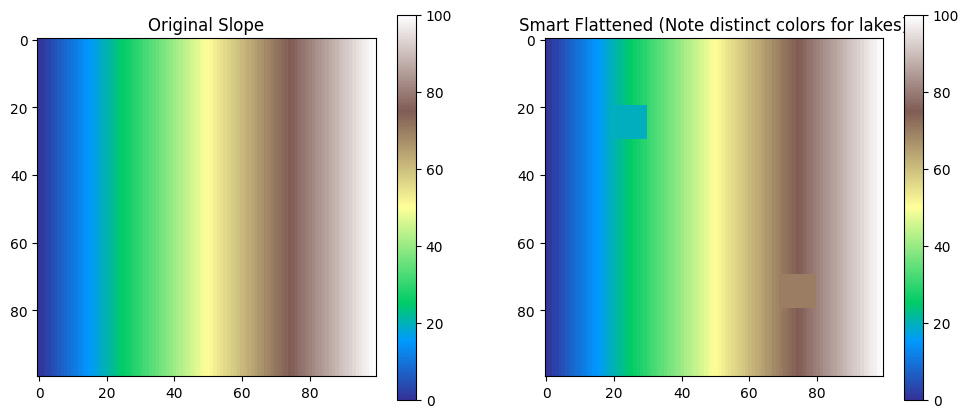

Low Lake Level: 19.19 (Should be ~20.0)
High Lake Level: 69.70 (Should be ~70.0)


In [7]:
# --- TEST CELL ---
import numpy as np
import matplotlib.pyplot as plt
from world_simulator import flatten_lakes_smart, flatten_by_mask

# 1. Create a Fake Terrain (Slope)
# 100x100 grid sloping from 0 to 100
dem = np.linspace(0, 100, 100).reshape(100, 1) * np.ones((1, 100))
dem = dem.T # Tilt it so it matches logic

# 2. Create a Fake Lake Mask
# Two lakes: One low (at x=20), One high (at x=80)
lake_mask = np.zeros((100, 100), dtype=bool)
lake_mask[20:30, 20:30] = True # Low Lake
lake_mask[70:80, 70:80] = True # High Lake

# 3. Apply Smart Flattening
flat_dem = flatten_lakes_smart(dem, lake_mask)

# 4. Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Original Slope")
plt.imshow(dem, cmap='terrain')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Smart Flattened (Note distinct colors for lakes)")
plt.imshow(flat_dem, cmap='terrain')
plt.colorbar()
plt.show()

# Verify Values
print(f"Low Lake Level: {flat_dem[25,25]:.2f} (Should be ~20.0)")
print(f"High Lake Level: {flat_dem[75,75]:.2f} (Should be ~70.0)")

In [3]:
import networkx as nx
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString

def assign_river_widths(G: nx.DiGraph, 
                        min_width: float = 10.0, 
                        max_width: float = 500.0, 
                        scale_factor: float = 1.5) -> gpd.GeoDataFrame:
    """
    Converts flow magnitude into physical river width using a logarithmic scaling function.
    
    FORMULA:
    Width = Min_Width + (log(Magnitude) * Scale_Factor)
    (Capped at max_width).
    
    Args:
        G: The enriched river DiGraph (from Step 2).
        min_width: Width of a source stream (Order 1) in meters.
        max_width: Hard cap for the widest river in meters.
        scale_factor: Multiplier to control widening rate.
        
    Returns:
        gpd.GeoDataFrame: River vectors with a 'width' column (in meters).
    """
    print(f"--- Phase 3: Physical Width Derivation ---")
    print(f"Params: Base={min_width}m, Cap={max_width}m, Scale={scale_factor}")
    
    river_segments = []
    
    # Iterate over edges
    # We use G.edges(data=True) to access attributes
    for u, v, data in G.edges(data=True):
        if 'geometry' not in data:
            continue
            
        # 1. Get Magnitude (Default to 1 if missing)
        # Ensure magnitude is at least 1 to avoid log(0) errors
        mag = max(data.get('magnitude', 1), 1)
        
        # 2. Apply Logarithmic Scaling
        # Natural Log (ln) grows fast initially then slows down, mimicking real rivers
        # formula: Base Width + (ln(Flow) * Factor)
        calc_width = min_width + (np.log(mag) * scale_factor)
        
        # 3. Apply Cap
        final_width = min(calc_width, max_width)
        
        # 4. Store Data
        river_segments.append({
            'geometry': data['geometry'],
            'source': u,
            'target': v,
            'magnitude': mag,
            'strahler': data.get('strahler', 1),
            'width': final_width
        })
    
    # 5. Convert to GeoDataFrame
    # We assume the graph nodes store the CRS, or we grab it from the geometry if possible.
    # Since we don't have the CRS object passed in explicitly, we will assume
    # the user handles CRS assignment or we infer it later. 
    # Ideally, pass CRS in or grab from a node attribute if stored.
    # For now, we return a GDF without CRS and set it outside.
    gdf = gpd.GeoDataFrame(river_segments)
    
    print(f"assigned widths to {len(gdf)} segments.")
    print(f"Width Range: {gdf['width'].min():.2f}m to {gdf['width'].max():.2f}m")
    
    return gdf

# --- VISUALIZER ---

def plot_river_physics(width_gdf, sea_gdf, lake_gdf=None):
    """
    Visualizes the ACTUAL physical footprint of the rivers.
    It buffers the lines by (width / 2) to show the river as a polygon.
    """
    fig, ax = plt.subplots(figsize=(15, 15), facecolor='white')
    
    # 1. Plot Context
    sea_gdf.plot(ax=ax, color='#e0f7fa', edgecolor='none', zorder=1)
    if lake_gdf is not None:
        lake_gdf.plot(ax=ax, color='#81d4fa', edgecolor='none', zorder=2)
        
    # 2. Create Physical Representation (Polygons)
    # We create a temporary column for visualization only
    # buffer(distance) -> distance is radius, so we use width / 2
    print("Buffering geometry for visualization...")
    
    # Check if CRS is projected (meters). If Lat/Lon, this visualization will fail/look huge.
    if width_gdf.crs and not width_gdf.crs.is_projected:
        print("WARNING: GDF is in Degrees! Buffering by meters will fail.")
    
    buffered_rivers = width_gdf.copy()
    buffered_rivers['geometry'] = buffered_rivers.geometry.buffer(buffered_rivers['width'] / 2)
    
    # 3. Plot Rivers
    # We color by width to emphasize the difference
    buffered_rivers.plot(ax=ax, 
                         column='width', 
                         cmap='Blues', 
                         legend=True,
                         legend_kwds={'label': "River Width (meters)"},
                         zorder=3)
    
    plt.title("Physical River Footprint (Buffered Geometry)")
    plt.axis('equal')
    plt.show()

--- Phase 3: Physical Width Derivation ---
Params: Base=20.0m, Cap=1000.0m, Scale=100.0
assigned widths to 113219 segments.
Width Range: 20.00m to 1000.00m
Buffering geometry for visualization...


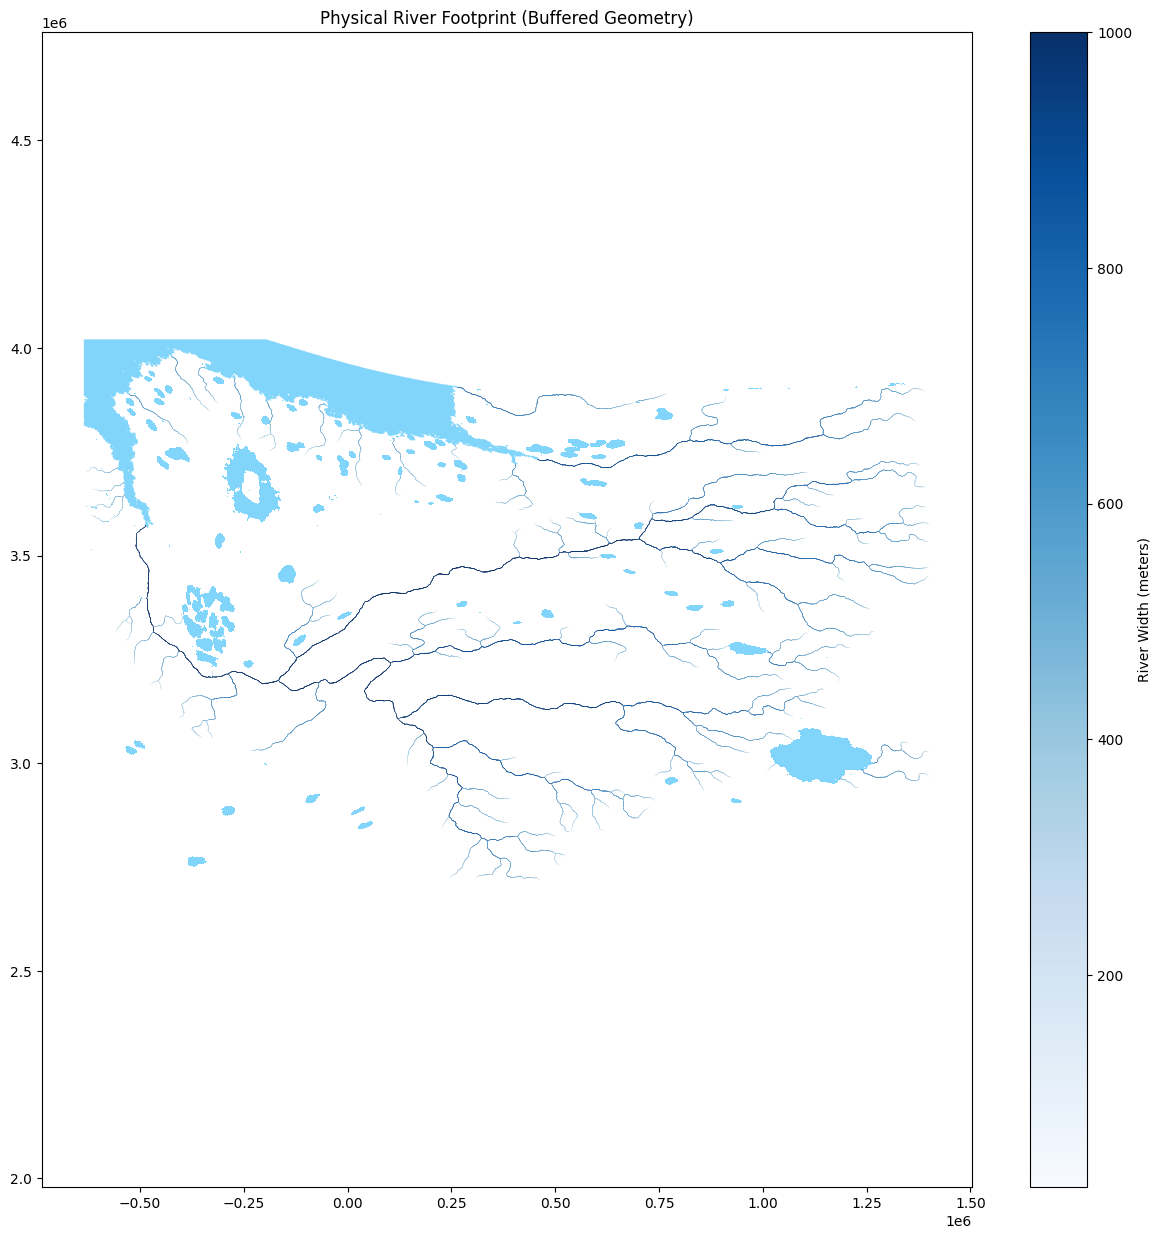

In [6]:
# 1. Run Width Calculation
# Tune scale_factor to make the Reik wide enough (try 1.5, 3.0, or 5.0)
rivers_with_width = assign_river_widths(
    dag_with_flow, 
    min_width=20.0,    # Source streams are 20m wide
    max_width=1000.0,   # The Reik is 800m wide at Altdorf
    scale_factor=100.0  # Multiplier for the log growth
)

# 2. Restore CRS (Important for buffering!)
rivers_with_width.set_crs(rivers.crs, inplace=True)

# 3. Visualize
plot_river_physics(rivers_with_width, sea, lakes)

In [9]:
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm

import logging

logger = logging.getLogger(__name__)

class CalculateFlowMagnitude:
    """
    A processing engine that calculates hydrological statistics 
    (Flow Accumulation and Strahler Stream Order) for a river DAG.
    """

    def __init__(self, graph: nx.DiGraph):
        # We work on a copy to avoid mutating the original graph unexpectedly
        # though usually in pipelines modifying in place is acceptable.
        self.graph = graph

    def run(self) -> nx.DiGraph:
        """
        Orchestrates the flow calculation pipeline.
        """
        logger.info("--- Phase 2: Flow Accumulation (Class-Based) ---")

        self._break_cycles()
        self._initialize_attributes()
        
        # Get execution order
        topo_order = self._get_topological_order()
        
        if topo_order:
            self._propagate_flow(topo_order)
            self._map_attributes_to_edges()
        else:
            logger.error("Skipping flow calculation due to topological errors.")

        return self.graph

    def _break_cycles(self):
        """Step 1: Detect and break cycles to enforce DAG structure."""
        if not nx.is_directed_acyclic_graph(self.graph):
            logger.warning("Graph contains cycles! Attempting to break them...")
            
            # Find cycles (returns a generator of lists)
            cycles = list(nx.simple_cycles(self.graph))
            logger.info(f"Found {len(cycles)} cycles.")
            
            count = 0
            for cycle in cycles:
                # Remove the edge returning to the start of the cycle (u -> v)
                # Cycle is [u, v, w, u] represented as nodes [u, v, w]
                u, v = cycle[-1], cycle[0]
                
                if self.graph.has_edge(u, v):
                    self.graph.remove_edge(u, v)
                    count += 1
            
            logger.info(f"Broke {count} cyclic edges.")
        else:
            logger.info("Graph is acyclic (DAG). No repairs needed.")

    def _initialize_attributes(self):
        """Step 2: Set baseline values for accumulation and order."""
        # flow_acc: Total number of upstream segments + 1 (itself)
        nx.set_node_attributes(self.graph, 1, 'flow_acc')
        # strahler: Stream order (1 = Headwater)
        nx.set_node_attributes(self.graph, 1, 'strahler')

    def _get_topological_order(self) -> list:
        """Step 3: Sort nodes from Headwaters -> Sea."""
        try:
            topo_order = list(nx.topological_sort(self.graph))
            logger.info(f"Topological sort successful. Processing {len(topo_order)} nodes.")
            return topo_order
        except nx.NetworkXUnfeasible:
            logger.critical("Graph still has cycles after repair attempt. Cannot compute flow.")
            return []

    def _propagate_flow(self, topo_order: list):
        """Step 4: Iterate downstream to sum accumulation and calculate hierarchy."""
        for node in topo_order:
            # Get upstream neighbors (predecessors)
            predecessors = list(self.graph.predecessors(node))
            
            if not predecessors:
                continue # It's a source, keep default values (1, 1)
                
            # --- A. Flow Accumulation (Simple Sum) ---
            incoming_flow = sum(self.graph.nodes[pred]['flow_acc'] for pred in predecessors)
            self.graph.nodes[node]['flow_acc'] += incoming_flow
            
            # --- B. Strahler Order (Hierarchical) ---
            incoming_strahlers = [self.graph.nodes[pred]['strahler'] for pred in predecessors]
            
            if incoming_strahlers:
                max_s = max(incoming_strahlers)
                # Strahler Rule: If two streams of max order join, order increments.
                # Otherwise, it stays the same.
                if incoming_strahlers.count(max_s) >= 2:
                    self.graph.nodes[node]['strahler'] = max_s + 1
                else:
                    self.graph.nodes[node]['strahler'] = max_s

    def _map_attributes_to_edges(self):
        """Step 5: Write node calculations to outgoing edges for vector mapping."""
        # Iterate over (u, v) pairs.
        # Since DiGraph is simple, we don't need 'keys=True'
        for u, v in self.graph.edges():
            # The properties of the edge u->v are defined by the accumulation at u
            flow_val = self.graph.nodes[u]['flow_acc']
            strahler_val = self.graph.nodes[u]['strahler']
            
            self.graph[u][v]['magnitude'] = flow_val
            self.graph[u][v]['strahler'] = strahler_val
            
        logger.info("Flow attributes mapped to edges.")



# --- VISUALIZER ---

def plot_river_hierarchy(DiG, sea_gdf, lake_gdf=None):
    """
    Visualizes the river network with line thickness based on Magnitude
    and color based on Strahler Order.
    """
    fig, ax = plt.subplots(figsize=(15, 15), facecolor='white')
    
    # 1. Context Layers
    sea_gdf.plot(ax=ax, color='#e0f7fa', edgecolor='none', zorder=1)
    if lake_gdf is not None:
        lake_gdf.plot(ax=ax, color='#81d4fa', edgecolor='none', zorder=2)
        
    # 2. Extract Edge Data for Plotting
    lines = []
    strahlers = []
    magnitudes = []
    
    for u, v, data in DiG.edges(data=True):
        if 'geometry' in data:
            lines.append(data['geometry'])
            # Default to 1 if missing
            strahlers.append(data.get('strahler', 1))
            magnitudes.append(data.get('magnitude', 1))
            
    if not lines:
        print("No river edges to plot!")
        return

    # 3. Create GeoDataFrame for Plotting
    # We use a temporary GDF to leverage matplotlib plotting
    plot_gdf = gpd.GeoDataFrame({
        'geometry': lines, 
        'strahler': strahlers,
        'magnitude': magnitudes
    }, crs=sea_gdf.crs)
    
    # 4. Dynamic Styling
    # Width: Logarithmic scaling so the Reik doesn't cover the whole map
    # We add 0.5 base width so source streams are visible
    linewidths = (np.log(plot_gdf['magnitude']) * 0.8) + 0.5
    
    # Color: Colormap based on Strahler Order
    # Low Order = Blue/Purple, High Order = Yellow/Red
    cmap = cm.get_cmap('plasma') 
    norm = Normalize(vmin=plot_gdf['strahler'].min(), vmax=plot_gdf['strahler'].max())
    
    # 5. Plot
    # We pass the calculated linewidths directly
    plot_gdf.plot(ax=ax, 
                  column='strahler', 
                  cmap=cmap, 
                  linewidth=linewidths,
                  zorder=3,
                  legend=True,
                  legend_kwds={'label': "Strahler Stream Order", 'shrink': 0.5})
    
    plt.title(f"River Network Hierarchy\n(Thickness = Flow Magnitude, Color = Stream Order)")
    plt.axis('equal')
    plt.show()

INFO: --- Phase 2: Flow Accumulation (Class-Based) ---
INFO: Graph is acyclic (DAG). No repairs needed.
INFO: Topological sort successful. Processing 113274 nodes.
INFO: Flow attributes mapped to edges.


/tmp/ipykernel_68338/3324183467.py:169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')


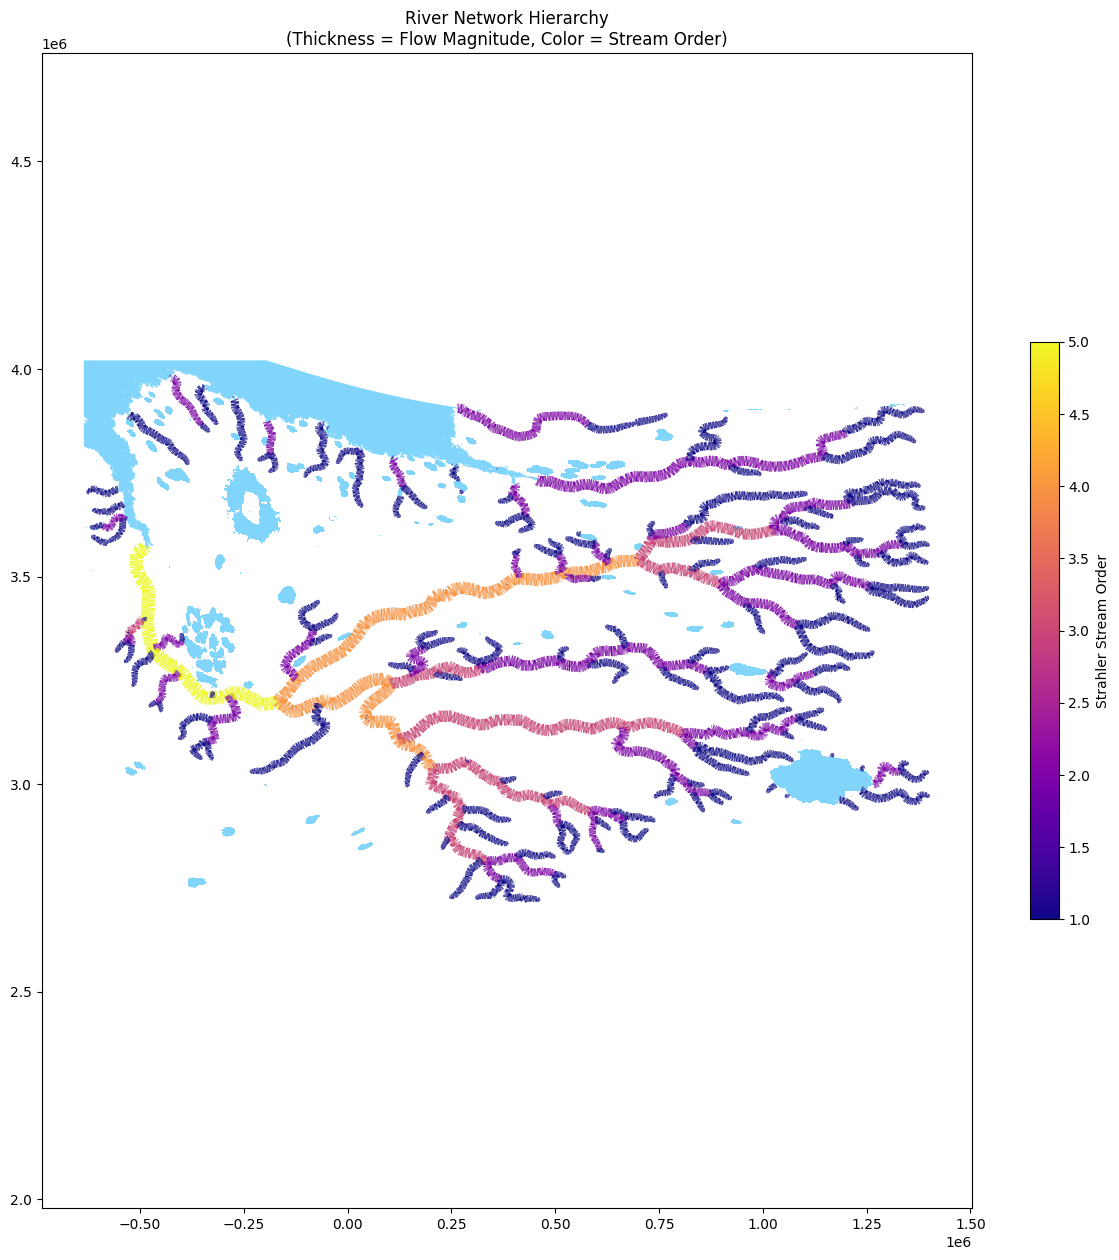

In [10]:
# Assuming you ran Phase 1 like this:
# analyzer = HydrologyAnalyzer(rivers, sea, lakes)
# oriented_rivers = analyzer.run()

# 1. Get the Directed Graph from the Phase 1 Analyzer
flow_calculator = CalculateFlowMagnitude(analyzer.DiG)

# 2. Calculate Magnitude
dag_with_flow = flow_calculator.run()

# 3. Visualize
plot_river_hierarchy(dag_with_flow, sea, lakes)

--- Testing Noise Function: generate_fractal_noise ---
Parameters: {'seed': 101, 'scale': 50.0, 'octaves': 6, 'persistence': 0.5, 'lacunarity': 2.0, 'mountain_mode': True}
INFO: Generating Fractal Noise (Seed: 101, Scale: 50.0, Octaves: 6)...


INFO: Noise generated. Range: 0.0000 to 0.6053

--- Output Statistics ---
Shape: (5281, 8197)
Min:   0.0000
Max:   0.6053
Mean:  0.1137
Std:   0.0848


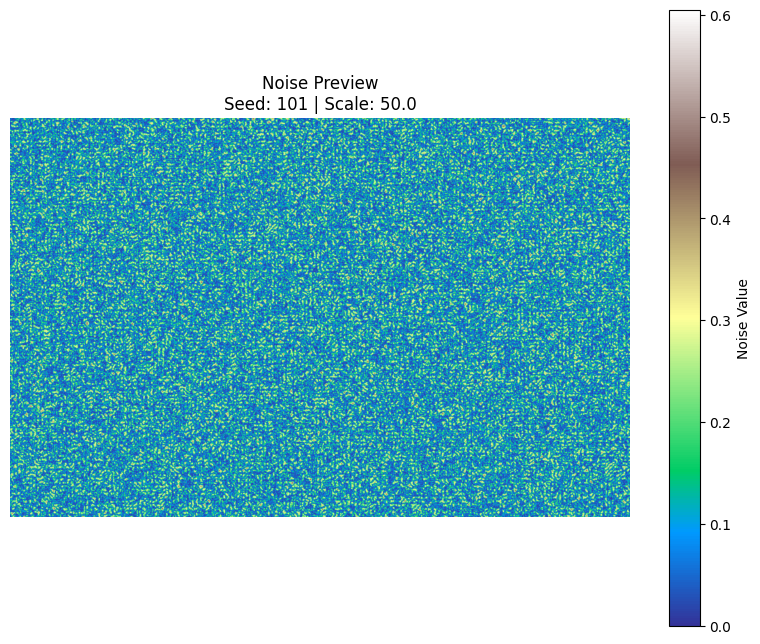

In [2]:
# Path to any existing raster (doesn't matter what's inside, just need the grid)
TEMPLATE_RASTER = "/home/pete/Documents/wfrp/source_rasters/wfrp_empire_topo_high_res.tif" 

# Test visualization
array, profile = test_noise(
    TEMPLATE_RASTER,
    generate_fractal_noise,
    seed=101,
    scale=50.0,
    octaves=6,
    persistence=0.5,
    lacunarity=2.0,
    mountain_mode=True
)

In [4]:
# --- RUNNER ---
import os
import geopandas as gpd
# 1. Load Data
# Assuming you have these files generated from your previous steps / provided
src_dir = "/home/pete/Documents/wfrp/source_vectors"

rivers_path = os.path.join(src_dir, "wfrp_empire_rivers_line.gpkg")
sea_path = os.path.join(src_dir, "wfrp_empire_sea_poly.gpkg")
lakes_path = os.path.join(src_dir, "wfrp_empire_lakes_poly.gpkg")


rivers = gpd.read_file(rivers_path) # The output from skeletonization
sea = gpd.read_file(sea_path)       # You need this
lakes = gpd.read_file(lakes_path)   # You need this (Canonical lakes)

/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'wfrp_empire_lakes_poly.gpkg': 'vectorized' (default), 'wfrp_empire_lakes'. Specify layer parameter to avoid this warning.
  result = read_func(


INFO: --- Phase 1: Hydrological Orientation (Class-Based) ---
INFO: Building base topology...
INFO: Integrating canonical lakes...
INFO: Added 7669 connections to virtual lake nodes.
INFO: Identifying discharge points...
INFO: Found 5550 river mouths.
INFO: Orienting flow direction (Sea -> Source)...


Orienting:  83%|█████████████████████████████████▉       | 120520/145766 [00:00<00:00, 140662.49it/s]

INFO: Reconstructing geometry...


INFO: Reconstruction complete. Valid segments: 113219. Dropped (Disconnected): 32500


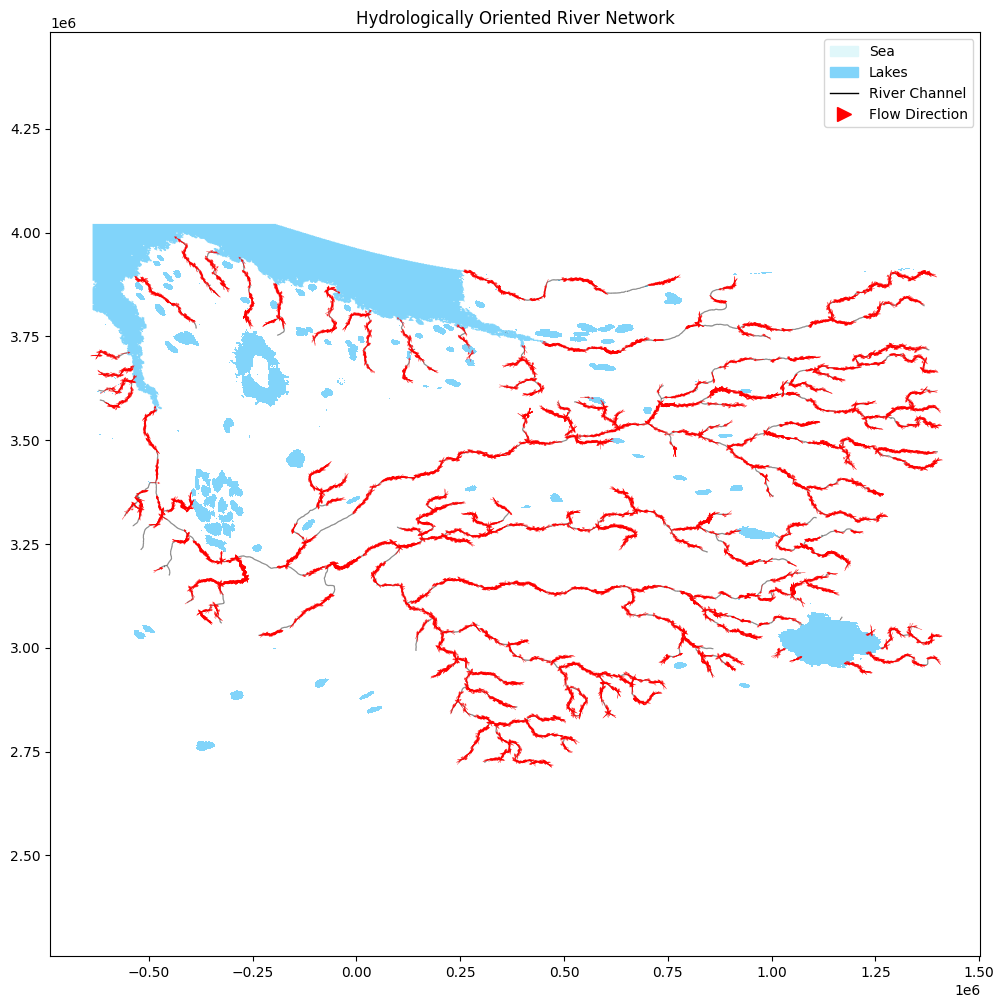

In [5]:
# 2. Instantiate and Run
analyzer = HydrologyAnalyzer(rivers, sea, lakes)
oriented_rivers = analyzer.run()
# 3. Visualize
plot_flow(oriented_rivers, sea, lakes)

## Vectorize the river net (legacy)

Old approach to vectorizing the river net, as extracted from the flow raster.

In [5]:
import rasterio
from rasterio import features
import geopandas as gpd
from shapely.geometry import shape
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
import pandas as pd
from shapely.ops import linemerge
from shapely.geometry import box
from centerline.geometry import Centerline
import fiona

In [2]:
# --- 1. Define Input and Output Files ---
FLOW_RASTER_PATH = "/home/pete/Documents/wfrp/physical_rasters/13_topo_rivers.tif"
VECTOR_POLY_PATH = "/home/pete/Documents/wfrp/physical_vectors/931_rivers_flow_values_cleaned.gpkg"
VECTOR_LINE_PATH = "/home/pete/Documents/wfrp/physical_vectors/933_rivers_line_segments.gpkg"
VECTOR_LINES_BINNED = "/home/pete/Documents/wfrp/physical_vectors/932_rivers_binned.gpkg"
THRESHOLD = 2500

In [15]:
# --- 2. Load Raster, Apply Threshold, and Skeletonize ---
print(f"Loading {FLOW_RASTER_PATH}...")
with rasterio.open(FLOW_RASTER_PATH) as src:
    image = src.read(1)
    transform = src.transform
    crs = src.crs
    print(f"Applying threshold (> {THRESHOLD})...")
    binary_image = image > THRESHOLD
    print("Skeletonizing the binary image...")
    skeleton = skeletonize(binary_image)
    skeleton = skeleton.astype(np.uint8)

# --- 3. Vectorize the Skeleton ---
print("Vectorizing the skeleton...")
shapes = features.shapes(
    skeleton, 
    mask=(skeleton > 0),
    transform=transform
)
geometries = [shape(geom) for geom, val in shapes]

# --- 4. Create GeoDataFrame ---
if geometries:
    print("Creating GeoDataFrame...")
    gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs)

    # --- 5. NEW: Sample Flow Values from Original Raster ---
    print("Sampling original flow accumulation values for each line...")
    # Calculate the mean flow value for the pixels each line crosses
    stats = rasterstats.zonal_stats(
        gdf,          # Your new vector lines
        image,        # The original flow accumulation data (as a NumPy array)
        affine=transform,
        stats=['max'] # You can also use 'max', 'min', etc.
    )
    
    # Extract the mean values and add them to a new column
    mean_flow_values = [s['max'] for s in stats]
    gdf['flow_acc'] = mean_flow_values
    
    # --- 6. Save the Final File ---
    print("Saving file with flow accumulation attributes...")
    gdf.to_file(VECTOR_POLY_PATH, driver='GPKG')
    print(f"Success! File saved to {VECTOR_POLY_PATH}")
else:
    print("No features found for the given threshold. Please try a lower value.")

Loading /home/pete/Documents/wfrp/physical_rasters/13_topo_rivers.tif...
Applying threshold (> 2500)...
Skeletonizing the binary image...
Vectorizing the skeleton...
Creating GeoDataFrame...
Sampling original flow accumulation values for each line...
Saving file with flow accumulation attributes...


/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Success! File saved to /home/pete/Documents/wfrp/physical_vectors/931_rivers_flow_values_cleaned.gpkg


In [6]:
layer_names = fiona.listlayers(VECTOR_POLY_PATH)
print(f"Layers found in file: {layer_names}")

Layers found in file: ['931_rivers_flow_values', '931_rivers_flow_values_cleaned']


Reading file: /home/pete/Documents/wfrp/physical_vectors/931_rivers_flow_values_cleaned.gpkg
Generating histogram...


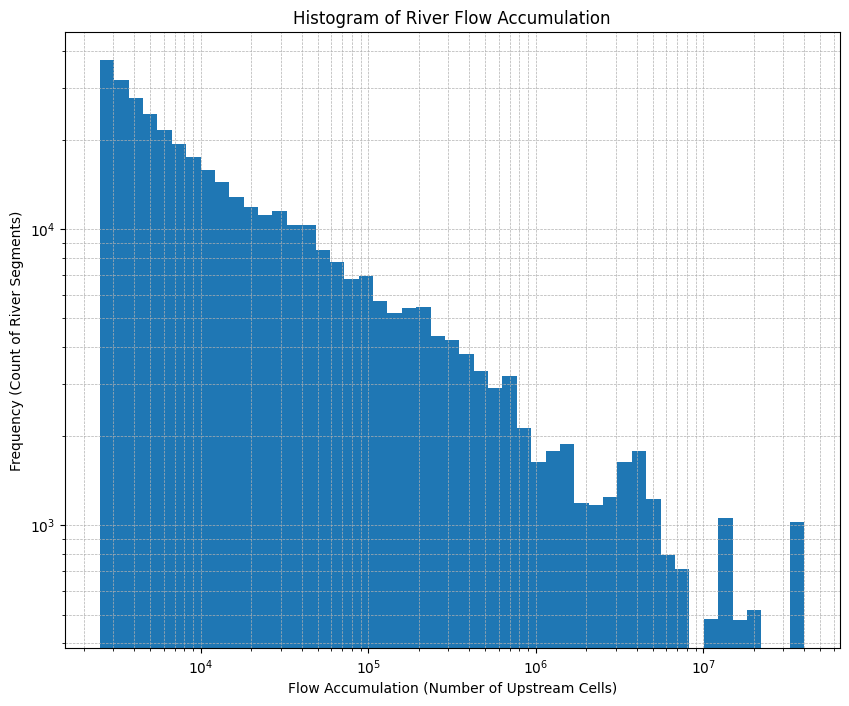

Done.


In [4]:
print(f"Reading file: {VECTOR_POLY_PATH}")
LAYER_TO_USE = '931_rivers_flow_values_cleaned'
gdf = gpd.read_file(VECTOR_POLY_PATH, layer=LAYER_TO_USE)

# Ensure there are positive flow values to plot on a log scale
flow_values = gdf['flow_acc'][gdf['flow_acc'] > 0]

if flow_values.empty:
    print("No positive flow accumulation values found to plot.")
else:
    print("Generating histogram...")
    # --- 2. Create the Plot ---
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Create a histogram of the flow accumulation values
    ax.hist(flow_values, bins=np.logspace(np.log10(flow_values.min()), np.log10(flow_values.max()), 50))

    # --- 3. Set Logarithmic Scales and Labels ---
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Histogram of River Flow Accumulation')
    ax.set_xlabel('Flow Accumulation (Number of Upstream Cells)')
    ax.set_ylabel('Frequency (Count of River Segments)')
    ax.grid(True, which="both", ls="--", linewidth=0.5)

    # --- 4. Show the Plot ---
    plt.show()
    print("Done.")

In [ ]:
import geopandas as gpd
from centerline.geometry import Centerline

print(f"Loading polygons from {VECTOR_POLY_PATH}...")
LAYER_TO_USE = '931_rivers_flow_values_cleaned'
gdf = gpd.read_file(VECTOR_POLY_PATH, layer=LAYER_TO_USE)

new_geometries = []
flow_values = []

print("Iterating and converting polygons to centerlines...")
# Iterate over each row (each tiny polygon)
for index, row in gdf.iterrows():
    try:
        # Calculate the centerline for this one polygon
        # Use an interpolation_distance based on your pixel size (e.g., 10)
        centerline_geom = Centerline(row.geometry, interpolation_distance=10).geometry
        
        # Add the new line and its original flow value to our lists
        new_geometries.append(centerline_geom)
        flow_values.append(row['flow_acc'])
    except Exception as e:
        # This catches any tiny polygons that are too small or weird to process
        print(f"Skipping a polygon (likely too small): {e}")

print("Creating new line GeoDataFrame...")
# Create a new GeoDataFrame from the centerline geometries
line_gdf = gpd.GeoDataFrame(
    {'flow_acc': flow_values},
    geometry=new_geometries,
    crs=gdf.crs
)

In [8]:
print(f"Saving final line file to: {VECTOR_LINE_PATH}")
line_gdf.to_file(VECTOR_LINE_PATH, driver='GPKG')

print("Done. You now have a true vector line file with flow values.")

Saving final line file to: /home/pete/Documents/wfrp/physical_vectors/933_rivers_line_segments.gpkg


/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Done. You now have a true vector line file with flow values.


In [3]:
print(f"Reading file: {VECTOR_LINE_PATH}")
gdf = gpd.read_file(VECTOR_LINE_PATH)

# --- 2. Categorize the Rivers ---
print("Categorizing rivers into manually defined size classes...")

# 1. DEFINE YOUR MANUAL BINS (Thresholds)
# The first value should be the minimum, the last should be infinity.
# Example: 0-1000 is Cat 1, 1001-5000 is Cat 2, etc.
bins = [
    -1,          # Start at -1 to include 0 in the first category
    10**5,        # Category 1: ( -1 to 1000]
    10**6,        # Category 2: (1000 to 5000]
    10**7,       # Category 3: (5000 to 20000]
    10**7.2,      # Category 4: (20000 to 100000]
    np.inf       # Category 5: (100000 to infinity]
]

# 2. DEFINE YOUR LABELS (Category numbers)
# Must be one less than the number of bins.
labels = [1, 2, 3, 4, 5]

# 3. CREATE THE NEW 'category' COLUMN
# pd.cut handles the logic of which bin each 'flow_acc' value falls into
gdf['category'] = pd.cut(
    gdf['flow_acc'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
).cat.add_categories(0).fillna(0)

Reading file: /home/pete/Documents/wfrp/physical_vectors/933_rivers_line_segments.gpkg
Categorizing rivers into manually defined size classes...


In [ ]:
# --- 4. CREATE GRID ---
GRID_SIZE = 50000
print("Creating processing grid...")
xmin, ymin, xmax, ymax = gdf.total_bounds
cols = list(np.arange(xmin, xmax + GRID_SIZE, GRID_SIZE))
rows = list(np.arange(ymin, ymax + GRID_SIZE, GRID_SIZE))

grid_cells = [box(x0, y0, x1, y1) for x0, x1 in zip(cols[:-1], cols[1:]) for y0, y1 in zip(rows[:-1], rows[1:])]
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs=gdf.crs)
grid_gdf['grid_id'] = grid_gdf.index # Add a simple ID for grouping

# --- 5. MAP PHASE: Split lines by grid ---
print("Map phase: Splitting lines against grid (this is the first big step)...")
# This is the new, crucial step: gpd.overlay()
# It replaces the loop, sindex.query, and clip.
# It correctly splits lines at grid boundaries.
split_lines_gdf = gpd.overlay(gdf, grid_gdf, how='intersection', keep_geom_type=True)

# --- 6. REDUCE-STEP-1: Merge within chunks ---
print("Reduce step 1: Merging lines within each grid cell...")
# Group by both grid_id AND category.
# Add observed=True to silence the warning.
grouped_in_cells = split_lines_gdf.groupby(['grid_id', 'category'], observed=True)

# Apply the merge logic.
# Use .union_all() to silence the deprecation warning.
merged_in_cells = grouped_in_cells['geometry'].apply(lambda x: linemerge(x.union_all()))

# --- 7. REDUCE-STEP-2: Final Merge ---
print("Reduce step 2: Merging lines from all cells...")

# We now have a pandas Series where the index is ('grid_id', 'category')
# Reset the index to make 'category' a column again
merged_in_cells_gdf = merged_in_cells.reset_index()

# Group again, this time *only* by category.
final_grouped = merged_in_cells_gdf.groupby('category', observed=True)

# Run the final linemerge
final_merged_geoms = final_grouped['geometry'].apply(lambda x: linemerge(x.union_all()))

# --- 8. Create and Save Final GeoDataFrame ---
print("Creating and saving final file...")
# Create the final GDF
# We pass the CRS *directly* to the constructor to fix the 3rd warning.
final_gdf = gpd.GeoDataFrame(geometry=final_merged_geoms, crs=gdf.crs).reset_index()

In [11]:
# Save
final_gdf.to_file(VECTOR_LINES_BINNED, driver='GPKG')

print("Done.")

/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Done.


## Make the small lakes

In [11]:
import whitebox
import rasterio
import numpy as np

In [15]:
DEM_IN_PATH = "/home/pete/Documents/wfrp/environment_layers/l001_dem.tif"
DEM_FAKE_CRS_PATH = "/home/pete/Documents/wfrp/physical_rasters/14_lakes_dem_fake_crs.tif" # New temporary file
DEM_FILLED_PATH = "/home/pete/Documents/wfrp/physical_rasters/14_lakes_fake_crs.tif"
SINK_DEPTHS_PATH = "/home/pete/Documents/wfrp/physical_rasters/14_lakes_small.tif"

In [13]:
print(f"Loading {DEM_IN_PATH}...")
with rasterio.open(DEM_IN_PATH) as src:
    dem_array = src.read(1)
    profile = src.profile # Get metadata

# --- THIS IS THE FIX ---
print("Replacing problematic CRS with a standard one (EPSG:32632)...")
# We use a standard UTM projection as a "spoof"
profile['crs'] = "EPSG:32632" 
# We keep the transform, as whitebox-tools will just use it for pixel size
# ------------------------

print(f"Saving 'fake CRS' DEM to {DEM_FAKE_CRS_PATH}...")
with rasterio.open(DEM_FAKE_CRS_PATH, 'w', **profile) as dst:
    dst.write(dem_array, 1)

print("'Fake CRS' copy created.")

Loading /home/pete/Documents/wfrp/environment_layers/l001_dem.tif...
Replacing problematic CRS with a standard one (EPSG:32632)...
Saving 'fake CRS' DEM to /home/pete/Documents/wfrp/physical_rasters/14_lakes_dem_fake_crs.tif...
'Fake CRS' copy created.


In [14]:
# Initialize WhiteboxTools
wbt = whitebox.WhiteboxTools()
wbt.verbose = True # Keep this on to see errors

# --- RUN SINK FILLING ---
print("Running whitebox.fill_depressions() on CRS-less file...")
wbt.fill_depressions(
    dem=DEM_FAKE_CRS_PATH,
    output=DEM_FILLED_PATH
)

Running whitebox.fill_depressions() on CRS-less file...
./whitebox_tools --run="FillDepressions" --dem='/home/pete/Documents/wfrp/physical_rasters/14_lakes_dem_fake_crs.tif' --output='/home/pete/Documents/wfrp/physical_rasters/14_lakes_fake_crs.tif' --fix_flats -v --compress_rasters=False

******************************
* Welcome to FillDepressions *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Finding pit cells: 12%
Finding pit cells: 25%
Finding pit cells: 37%
Finding pit cells: 50%
Finding pit cells: 62%
Finding pit cells: 75%
Finding pit cells: 87%
Finding pit cells: 100%
Filling depressions: 0%
Filling depressions: 1%
Filling depressions: 2%
Filling depressions: 3%
Filling depressions: 4%
Filling depressions: 5%
Filling depressions: 6%
Filling depressions: 7%
Filling depressions: 8%
Filling depressions: 9%
Filling depressions: 10%
Filling depressions: 11%
Filling depressions: 12%
Filling depressions: 13%
Filling depre

0

In [17]:
print("Calculating sink depths...")

# Read the original file to get its metadata (profile)
with rasterio.open(DEM_IN_PATH) as original_src:
    original_dem = original_src.read(1).astype(np.float32)
    original_profile = original_src.profile # Has the correct, original CRS

# Read the new filled file
with rasterio.open(DEM_FILLED_PATH) as filled_src:
    filled_dem = filled_src.read(1).astype(np.float32)

# Check if shapes match (they should)
if original_dem.shape != filled_dem.shape:
    print("Error: Shape mismatch. Aborting.")
else:
    # Calculate depths
    sink_depths = filled_dem - original_dem
    nodata = original_profile.get('nodata')
    
    # Handle nodata
    if nodata is not None:
        sink_depths[original_dem == nodata] = nodata

    # Update profile to float32
    original_profile.update(dtype='float32')

    # --- SAVE WITH ORIGINAL CRS ---
    print(f"Saving sink depths (with original CRS) to {SINK_DEPTHS_PATH}...")
    with rasterio.open(SINK_DEPTHS_PATH, 'w', **original_profile) as dst:
        dst.write(sink_depths, 1)

    print("Processing complete.")

Calculating sink depths...
Saving sink depths (with original CRS) to /home/pete/Documents/wfrp/physical_rasters/14_lakes_small.tif...
Processing complete.


In [20]:
import rasterio
import numpy as np
from skimage import measure

SINK_DEPTHS_IN_PATH = "/home/pete/Documents/wfrp/physical_rasters/14_lakes_small.tif"
SMALL_LAKES_OUT_PATH = "/home/pete/Documents/wfrp/physical_rasters/14_lakes_small_CLEANED.tif"

In [29]:
# Define the maximum size (in pixels) for a lake to be KEPT.
# Any contiguous basin larger than this will be erased.
# This is your 'N' value. Try a few values, e.g., 10000.
MAX_LAKE_SIZE_PIXELS = 10000 
# ----------------------------------------

print(f"Loading {SINK_DEPTHS_IN_PATH}...")
with rasterio.open(SINK_DEPTHS_IN_PATH) as src:
    sink_depths = src.read(1).astype(np.float32)
    profile = src.profile # Get metadata
    nodata = profile.get('nodata')

    # Make a copy for our output
    final_output_array = sink_depths.copy()

Loading /home/pete/Documents/wfrp/physical_rasters/14_lakes_small.tif...


In [30]:
# --- 2. Create a Binary Mask ---
# We need a simple 1s (basin) and 0s (not basin) array
if nodata is not None:
    binary_basins = (sink_depths > 0) & (sink_depths != nodata)
else:
    binary_basins = (sink_depths > 0)

# --- 3. Find and Label All Blobs ---
print("Finding all connected basins...")
# This function finds all contiguous "blobs" and gives each a unique integer ID
# connectivity=2 means it checks 8-way (including diagonals)
labeled_array = measure.label(binary_basins, connectivity=2)

Finding all connected basins...


In [31]:
# --- 4. Count Sizes and Find "Bad" (Large) Labels ---
print("Calculating size of each basin...")
# np.bincount is a very fast way to count pixels for each label
# The index is the label ID, the value is the pixel count
label_sizes = np.bincount(labeled_array.ravel())

# Find the label IDs of all blobs that are TOO BIG
all_label_ids = np.arange(len(label_sizes))
# Note: we skip label 0, which is the background
bad_label_ids = all_label_ids[label_sizes > MAX_LAKE_SIZE_PIXELS]

print(f"Found {len(bad_label_ids)} basins that are too large and will be removed.")

Calculating size of each basin...
Found 197 basins that are too large and will be removed.


In [32]:
# --- 5. Create a "Kill Mask" and Apply It ---
# np.isin() is a fast way to find all pixels that belong to a "bad" label
kill_mask = np.isin(labeled_array, bad_label_ids)

# Set all pixels in the original array that are part of a "bad" blob to 0
final_output_array[kill_mask] = 0

print("Large basins have been erased.")

# --- 6. Save the Cleaned Raster ---
print(f"Saving cleaned raster to {SMALL_LAKES_OUT_PATH}...")
with rasterio.open(SMALL_LAKES_OUT_PATH, 'w', **profile) as dst:
    dst.write(final_output_array, 1)

print("Done.")

Large basins have been erased.
Saving cleaned raster to /home/pete/Documents/wfrp/physical_rasters/14_lakes_small_CLEANED.tif...
Done.
